In [1]:
import os
from pathlib import Path
import json

import numpy as np
import cv2 as cv
from skimage.io import imread, imsave
from skimage import exposure

import matplotlib.pyplot as plt

np.random.seed(42) # ustawianie wartości ziarna randomowego w celu reprodukowalności wyników

In [2]:
def load_train_data(input_dir, newSize=(64,64)):
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)
                train_img.append(img)
        categories_count.append(count)
    X = {"values": np.array(train_img), "categories_name": categories_name,
         "categories_count": categories_count, "labels": labels}
    return X

In [3]:
def load_test_data(input_dir, newSize=(64,64)):
    image_path = Path(input_dir)
    labels_path = image_path.parents[0] / 'test_labels.json'
    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)
    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])
    categories_count.append(count)
    test_img = []
    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)
        test_img.append(img)
        labels.append(e['value'])

    X = {"values": np.array(test_img), "categories_name": categories_name,
         "categories_count": categories_count, "labels": labels}
    return X


In [4]:
def sombel(image):
    sobelx = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=5)
    sobel_total = np.sqrt(sobelx**2 + sobely**2)
    return np.uint8(sobel_total)

Implementacja warstw sieci neuronowej

In [5]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

Implementacja funkcji aktywacji

In [6]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

In [7]:
class Sigmoid:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))

    def backward(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

In [8]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs

        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)
        self.output = probabilities

    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)

Algorytm propagacji wstecznej

In [9]:
class SGD:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)

            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1

Funkcja bledu

In [10]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [11]:
class CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

Implementacja modelu sieci neuronowej

In [29]:
class Model:
    def __init__(self, layers):
        self.layers = layers

    def _forward(self, X):
        for layer in self.layers:
            layer.forward(X)
            X = layer.output
        return X

    def _backward(self, dinputs, optimizer):
        for layer in reversed(self.layers):
            layer.backward(dinputs)
            dinputs = layer.dinputs
        optimizer.pre_update_params()
        for layer in self.layers:
            if hasattr(layer, 'weights'):
                optimizer.update_params(layer)
        optimizer.post_update_params()

    @staticmethod
    def get_batches(X, y, batch_size):
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        for start_idx in range(0, len(X) - batch_size + 1, batch_size):
            excerpt = indices[start_idx:start_idx + batch_size]
            yield X[excerpt], y[excerpt]


    def fit(self, X_data, y_data, X_val_data, y_val_data,
            epochs, loss_function, optimizer, batch_size=128):
        ls = []
        acc = []
        for epoch in range(epochs):
            loss_acum = []
            for X_batch, y_batch in self.get_batches(X_data, y_data, batch_size):
                output = self._forward(X_batch)
                loss = loss_function.calculate(output, y_batch)
                loss_function.backward(output, y_batch)
                self._backward(loss_function.dinputs, optimizer)
                loss_acum.append(loss)
            ls.append([epoch, np.mean(loss_acum)])

            if not epoch % 50:
                output = self._forward(X_val_data)
                predictions = np.argmax(output, axis=1)
                y = y_val_data.copy()
                if len(y.shape) == 2:
                       y = np.argmax(y, axis=1).copy()
                accuracy = np.mean(predictions == y)
                print(f'epoch: {epoch}, ' +
                      f'acc: {accuracy:.3f} ' +
                      f'loss: {np.mean(loss_acum)}')
                acc.append([epoch, accuracy])
        return np.array(acc), np.array(ls)

    def predict(self, X):
        return np.argmax(self._forward(X), axis=1)

Preprocessing danych

In [30]:
def create_label_to_num_mapping(categories):
    return {name: i for i, name in enumerate(categories)}

def convert_labels_to_one_hot(labels, label_to_num):
    one_hot_labels = []
    for label in labels:
        tmp = np.zeros((1, len(label_to_num)))
        tmp[0, label_to_num[label]] = 1
        one_hot_labels.append(tmp)
    return np.array(one_hot_labels).reshape(-1, len(label_to_num))

def normalize_images(images, negative_values=False):
    if not negative_values:
        return images.reshape(-1, 64*64*4) / 255.0
    else:
        return (images.reshape(-1, 64*64*4) - 127.5) / 127.5

def shuffle_data(X, y):
    num_examples = X.shape[0]
    indices = np.arange(num_examples)
    np.random.shuffle(indices)
    return X[indices], y[indices]

Dane treningowe dla sieci z funkcja aktywacji Sigmoid

In [31]:
train_data = load_train_data('./train_test_sw/train_sw')
label_to_num = create_label_to_num_mapping(train_data['categories_name'])
y_sig = convert_labels_to_one_hot(train_data['labels'], label_to_num)
X_sig = normalize_images(train_data['values'], negative_values=True)
X_sig, y_sig = shuffle_data(X_sig, y_sig)

test_data = load_test_data('./train_test_sw/test_sw')
y_val_sig = convert_labels_to_one_hot(test_data['labels'], label_to_num)
X_val_sig = normalize_images(test_data['values'], negative_values=True)
X_val_sig, y_val_sig = shuffle_data(X_val_sig, y_val_sig)

Przetrenujmy pierwsza siec neuronowa, z wejsciem o rozmiarze 16384 (rozmiar obrazku 64x64, oraz 4 kanaly Red, Green, Blue oraz Alpha), wartswie wewnetrznej o rozmiarze 128, oraz wyjsciowej o rozmiarze 5; 5 wynika z ilosci klas.

In [32]:
model_sigmoid = Model([
    Dense(64*64*4, 128),
    Sigmoid(), # funkcja aktywacyjna Sigmoid bierze pod uwage wartosci minusowe, dlatego dataset zostal znormalizowany z wartoscami minusowymi
    Dense(128, 5),
    Softmax()])

acc, loss = model_sigmoid.fit(X_sig, y_sig,
                              X_val_sig, y_val_sig,
                              batch_size=12,
                              epochs=1000,
                              loss_function=CategoricalCrossentropy(),
                              optimizer=SGD(learning_rate=1e-3, momentum=0.7, decay=2e-5))


epoch: 0, acc: 0.220 loss: 1.6127275973968511
epoch: 50, acc: 0.402 loss: 1.3790695251341456
epoch: 100, acc: 0.564 loss: 1.0847522501558506
epoch: 150, acc: 0.653 loss: 0.8809358655340805
epoch: 200, acc: 0.641 loss: 0.7338559857199459
epoch: 250, acc: 0.649 loss: 0.6289804557275116
epoch: 300, acc: 0.707 loss: 0.5480626056241775
epoch: 350, acc: 0.741 loss: 0.48195593263601355
epoch: 400, acc: 0.710 loss: 0.4324913176277179
epoch: 450, acc: 0.757 loss: 0.3829671623857159
epoch: 500, acc: 0.741 loss: 0.35889932469236835
epoch: 550, acc: 0.741 loss: 0.3237007270842347
epoch: 600, acc: 0.730 loss: 0.29634885257025556
epoch: 650, acc: 0.764 loss: 0.2884160366015281
epoch: 700, acc: 0.761 loss: 0.2585873130032528
epoch: 750, acc: 0.768 loss: 0.23484167213101143
epoch: 800, acc: 0.768 loss: 0.21996649666472504
epoch: 850, acc: 0.737 loss: 0.20597770422645945
epoch: 900, acc: 0.757 loss: 0.19399445622197922
epoch: 950, acc: 0.734 loss: 0.18849114343235962


Wyniki treningu. 

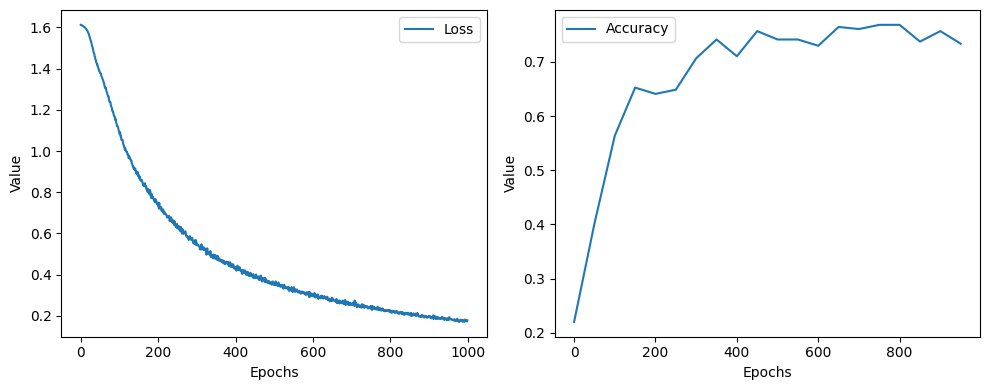

In [33]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(loss[:, 0], loss[:, 1], label='Loss')
axs[1].plot(acc[:, 0], acc[:, 1], label='Accuracy')

for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()


W przypadku powyzszego learning rate'u widac, ze model jest wstanie znalezc globalne minimum.

Na wykresie reprezentujacym accuracy jestesmy wstanie zobaczyc, ze trening na danych uczacych rowniez ma wplyw na dzialanie modelu na danych walidacyjnych - danych ktorych wczesniej nigdy nie widzial. Jest to wazna metryka, poniewaz pozwala nam przewidziec jak dobrze model moze sobie radzic po wdrozeniu.

Oczywiscie sam learning rate moze nie wystarczyc.
Oprocz learning rate'u, implementacja SGD posiada decay i momentum. Waga momentum ma wply na to jak "zwrotna" jest optymalizacja SGD; im wieksze momentum, tym SGD jest mniej czuly na male, lokalne minima. Decay natomiast pozwala zmniejszac krok w kierunku minima wraz z uplywem epok; tak naprawde wspolpracuje wraz z samym algorytmem wstecznej propagacji aby zmniejszyc krok, im model znajduje sie blizej globalnego minima.

Kilkukrotnie probowalem wytrenowac ten model za pomoca samego learning rate'u. Jednak bardzo latwo bylo mu "przestrzelic". Na skutek tego wykres lossu, wystrzeliwal i stawal sie bardzo chaotyczny, jak jest to widoczne ponizej. Oczywiscie krok uczacy byl rowniez zbyt wysoki.


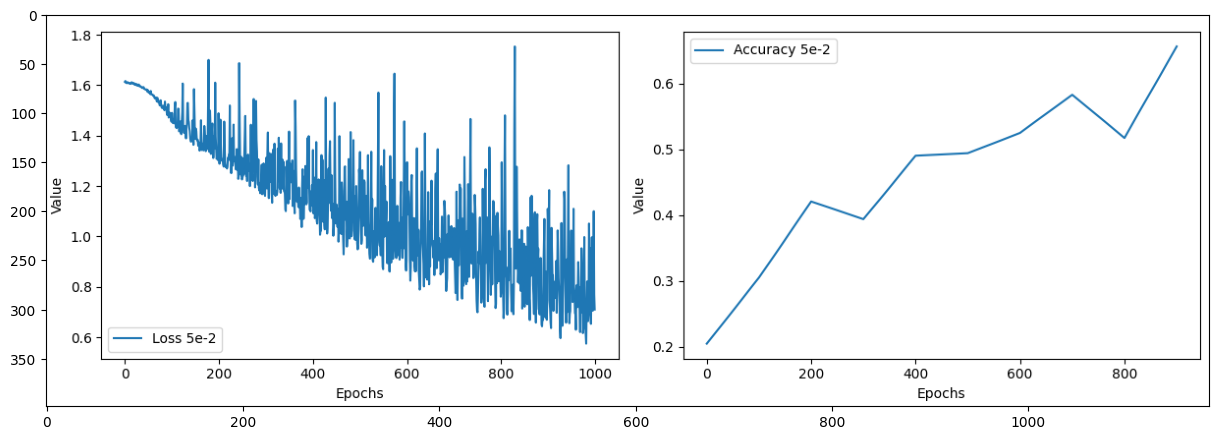

In [37]:
import matplotlib.image as mpimg
plt.figure(figsize=(15,15))
plt.imshow(mpimg.imread('/home/potato/Pictures/Screenshots/training.png'))
plt.show()

## Generowanie danych treningowych dla modelu wykorzystujacego aktywacje ReLU

In [47]:
train_data = load_train_data('./train_test_sw/train_sw')
label_to_num = create_label_to_num_mapping(train_data['categories_name'])
y = convert_labels_to_one_hot(train_data['labels'], label_to_num)
X = normalize_images(train_data['values'])
X_relu, y_relu = shuffle_data(X, y)

test_data = load_test_data('./train_test_sw/test_sw')
y_val = convert_labels_to_one_hot(test_data['labels'], label_to_num)
X_val = normalize_images(test_data['values'])
X_val_relu, y_val_relu = shuffle_data(X_val, y_val)

Poniewaz funkcja aktywacji ReLU ucina wartosci mniejsze od zera, nie bedziemy normalizowac obrazow w taki sam sposob, jak bylo to uczynione poprzednio. Tym razem, najmniejsza wartosc w datasetcie bedzie rowna 0

In [48]:
print(f"Najmniejsz wartosc datasetu: {X_relu.min()}")
print(f"Najwieksza wartosc datasetu: {X_relu.max()}")

Najmniejsz wartosc datasetu: 0.0
Najwieksza wartosc datasetu: 1.0


In [65]:
model_relu = Model([
    Dense(64*64*4, 128),
    ReLU(),
    Dense(128, 5),
    Softmax()
])

oprimizer = SGD(learning_rate=3e-3, momentum=0.4, decay=5e-5)
loss_function = CategoricalCrossentropy()
acc, loss = model_relu.fit(X_relu, y_relu,
                           X_val_relu, y_val_relu,
                           2500,
                           loss_function, oprimizer)

epoch: 0, acc: 0.205 loss: 1.6109466527387228
epoch: 50, acc: 0.328 loss: 1.5789582758238478
epoch: 100, acc: 0.359 loss: 1.4654317330214663
epoch: 150, acc: 0.363 loss: 1.377546683696786
epoch: 200, acc: 0.479 loss: 1.29010749828001
epoch: 250, acc: 0.529 loss: 1.1927420086724152
epoch: 300, acc: 0.521 loss: 1.0941687037240606
epoch: 350, acc: 0.606 loss: 1.0155240744869614
epoch: 400, acc: 0.610 loss: 0.939130239080712
epoch: 450, acc: 0.614 loss: 0.8879610678360008
epoch: 500, acc: 0.587 loss: 0.8616406605869515
epoch: 550, acc: 0.579 loss: 0.8111517787693718
epoch: 600, acc: 0.664 loss: 0.743636721966396
epoch: 650, acc: 0.707 loss: 0.7204908967769273
epoch: 700, acc: 0.672 loss: 0.7366243216166838
epoch: 750, acc: 0.676 loss: 0.7964986091253345
epoch: 800, acc: 0.649 loss: 0.6155325989364864
epoch: 850, acc: 0.649 loss: 0.5673870433442411
epoch: 900, acc: 0.741 loss: 0.5424349529288509
epoch: 950, acc: 0.610 loss: 0.6529809801875506
epoch: 1000, acc: 0.753 loss: 0.5364960625830555

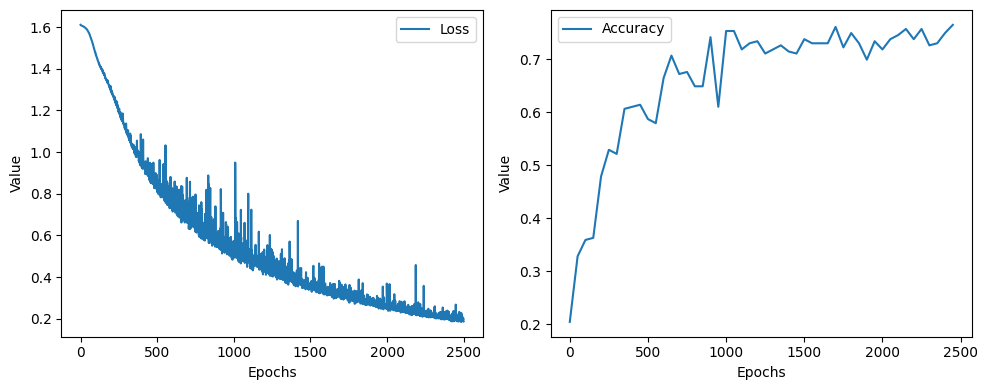

In [66]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(loss[:, 0], loss[:, 1], label='Loss')
axs[1].plot(acc[:, 0], acc[:, 1], label='Accuracy')

for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()


Jak widac trening modelu z aktywacja ReLU wymagal o wiele wiecej iteracji, aby osognac podobna wartosc Accuracy.

Stalo sie to z kilku powodow:

1. Zmienila sie funkcja aktywacji. Poniewaz wartosci, ktore juz przeszly funkcje aktywacji mogly byc tylko nie negatywne, moglo to ograniczyc ilosc informacji, ktora przechodzila z jednej warstwy do nastepnej.
2. Krok uczenia zostal zwiekszony; ze wzgledu na to, trudnym bylo dla modelu znalezienie globalnego minimum - mozna to wywnioskowac po ostrych wzrostach i spadkach wartosci funkcji bledu. Z tego samego powodu nalezalo zmniejszyc momentum optymalizatora, w celu unikniecia jeszcze wiekszego "przestrzeliwania". Decay zostal natomiast zwiekszony, aby zmniejszyc wspolczynnik uczenia podczas dalszych epok treningu.


Jednak mozna zauwazyc, ze pomimo tylu przeciwnosci, model zdolal osiagnac accuracy na poziomie 76. Oczywiscie zawdziecza ten wynik znacznie dluzszemu treningowi.

Zobaczmy jak modele dadza sobie rade z zaugmentowanymi danymi

Augmentacja danych trenujacych

In [ ]:
from PIL import Image

In [72]:
def sobel(input_path, output_path):
    pil_image = Image.open(input_path).convert('RGBA')
    image_array = np.array(pil_image.convert('RGB'))
    image_bgr = cv.cvtColor(image_array, cv.COLOR_RGB2BGR)
    sobelx = cv.Sobel(image_bgr, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(image_bgr, cv.CV_64F, 0, 1, ksize=5)
    sobel_combined = cv.addWeighted(cv.convertScaleAbs(sobelx), 0.5, cv.convertScaleAbs(sobely), 0.5, 0)
    sobel_rgb = cv.cvtColor(sobel_combined, cv.COLOR_BGR2RGB)
    pil_image_sobel = Image.fromarray(sobel_rgb).convert('RGBA')
    pil_image_sobel = pil_image_sobel.resize((256, 256), Image.Resampling.LANCZOS)
    pil_image_sobel.save(output_path)

Augmentowanie danych

In [74]:
train_dir_path = './train_test_sw/train_sw/'
augment_train_dir_path  = './train_test_sw_augment/train_sw'
os.makedirs(augment_train_dir_path, exist_ok=True)
for directory in os.listdir(train_dir_path):
    augment_dir_path = os.path.join(augment_train_dir_path, directory)
    dir_path = os.path.join(train_dir_path, directory)
    if not os.path.exists(augment_dir_path):
        os.mkdir(augment_dir_path)
    for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        augment_file_path = os.path.join(augment_dir_path, file)
        sobel(file_path, augment_file_path)
        

In [75]:
import shutil

test_dir_path = './train_test_sw/test_sw'
augment_test_dir_path = './train_test_sw_augment/test_sw'
os.makedirs(augment_test_dir_path, exist_ok=True)
for file in os.listdir(test_dir_path):
    test_file = os.path.join(test_dir_path, file)
    augment_test_file = os.path.join(augment_test_dir_path, file)
    sobel(test_file, augment_test_file)

shutil.copy('./train_test_sw/test_labels.json', './train_test_sw_augment/test_labels.json')

'./train_test_sw_augment/test_labels.json'

In [76]:
train_data = load_train_data('./train_test_sw_augment/train_sw')
label_to_num = create_label_to_num_mapping(train_data['categories_name'])
y_sig = convert_labels_to_one_hot(train_data['labels'], label_to_num)
X_sig = normalize_images(train_data['values'], negative_values=True)
X_sig, y_sig = shuffle_data(X_sig, y_sig)

test_data = load_test_data('./train_test_sw_augment/test_sw')
y_val_sig = convert_labels_to_one_hot(test_data['labels'], label_to_num)
X_val_sig = normalize_images(test_data['values'], negative_values=True)
X_val_sig, y_val_sig = shuffle_data(X_val_sig, y_val_sig)

Ponowny trening modeli

In [82]:
acc, loss = model_sigmoid.fit(X_sig, y_sig,
                              X_val_sig, y_val_sig,
                              batch_size=12,
                              epochs=1000,
                              loss_function=CategoricalCrossentropy(),
                              optimizer=SGD(learning_rate=1e-3, momentum=0.7, decay=2e-5))

epoch: 0, acc: 0.251 loss: 1.5811955650375236
epoch: 50, acc: 0.371 loss: 0.09766434139297116
epoch: 100, acc: 0.359 loss: 0.04087702100467474
epoch: 150, acc: 0.336 loss: 0.024912960651045663
epoch: 200, acc: 0.328 loss: 0.017740107661816114
epoch: 250, acc: 0.324 loss: 0.013911598333174915
epoch: 300, acc: 0.313 loss: 0.011507917599853918
epoch: 350, acc: 0.309 loss: 0.009842614375383155
epoch: 400, acc: 0.309 loss: 0.008653194626500412
epoch: 450, acc: 0.309 loss: 0.0077355990790219835
epoch: 500, acc: 0.309 loss: 0.007019279935358225
epoch: 550, acc: 0.309 loss: 0.006470542151978584
epoch: 600, acc: 0.309 loss: 0.006035454181363971
epoch: 650, acc: 0.309 loss: 0.005626505802559084
epoch: 700, acc: 0.309 loss: 0.00530860897619156
epoch: 750, acc: 0.309 loss: 0.0050182667843466115
epoch: 800, acc: 0.309 loss: 0.004774752235243081
epoch: 850, acc: 0.305 loss: 0.004550622431336467
epoch: 900, acc: 0.305 loss: 0.004364849116934384
epoch: 950, acc: 0.305 loss: 0.004157262288551559


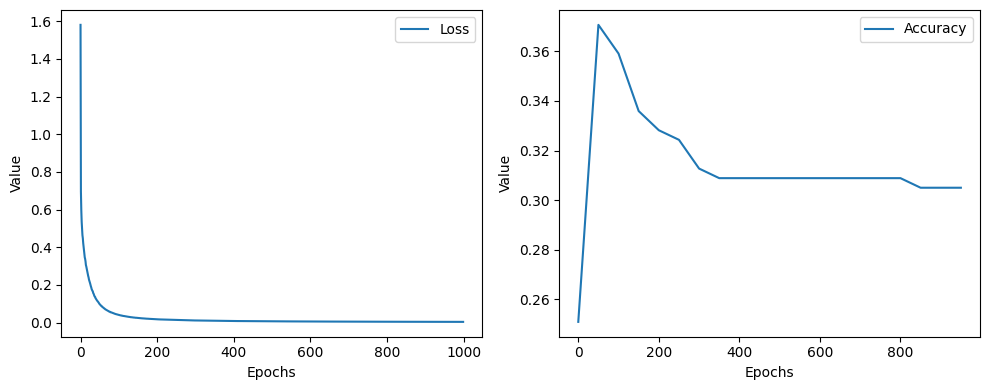

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(loss[:, 0], loss[:, 1], label='Loss')
axs[1].plot(acc[:, 0], acc[:, 1], label='Accuracy')

for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

In [84]:
train_data = load_train_data('./train_test_sw_augment/train_sw')
label_to_num = create_label_to_num_mapping(train_data['categories_name'])
y = convert_labels_to_one_hot(train_data['labels'], label_to_num)
X = normalize_images(train_data['values'])
X_relu, y_relu = shuffle_data(X, y)

test_data = load_test_data('./train_test_sw_augment/test_sw')
y_val = convert_labels_to_one_hot(test_data['labels'], label_to_num)
X_val = normalize_images(test_data['values'])
X_val_relu, y_val_relu = shuffle_data(X_val, y_val)

In [85]:
oprimizer = SGD(learning_rate=3e-3, momentum=0.4, decay=5e-5)
loss_function = CategoricalCrossentropy()
acc, loss = model_relu.fit(X_relu, y_relu,
                           X_val_relu, y_val_relu,
                           2500,
                           loss_function, oprimizer)

epoch: 0, acc: 0.409 loss: 5.416392069738564
epoch: 50, acc: 0.691 loss: 0.5182129345938271
epoch: 100, acc: 0.730 loss: 0.3013255399353599
epoch: 150, acc: 0.699 loss: 0.16333067392900313
epoch: 200, acc: 0.722 loss: 0.11875726180783105
epoch: 250, acc: 0.764 loss: 0.08070333603783633
epoch: 300, acc: 0.761 loss: 0.06707110595762246
epoch: 350, acc: 0.745 loss: 0.05003831231354798
epoch: 400, acc: 0.757 loss: 0.04052698383405343
epoch: 450, acc: 0.753 loss: 0.03454747110138971
epoch: 500, acc: 0.749 loss: 0.029625356617595945
epoch: 550, acc: 0.757 loss: 0.026115097186379242
epoch: 600, acc: 0.757 loss: 0.023020254733717535
epoch: 650, acc: 0.764 loss: 0.02086852610505297
epoch: 700, acc: 0.757 loss: 0.018853735434805875
epoch: 750, acc: 0.753 loss: 0.017154712602256823
epoch: 800, acc: 0.757 loss: 0.01581688098134966
epoch: 850, acc: 0.757 loss: 0.014675365507583173
epoch: 900, acc: 0.757 loss: 0.01369845882163031
epoch: 950, acc: 0.761 loss: 0.012770497343206602
epoch: 1000, acc: 0.

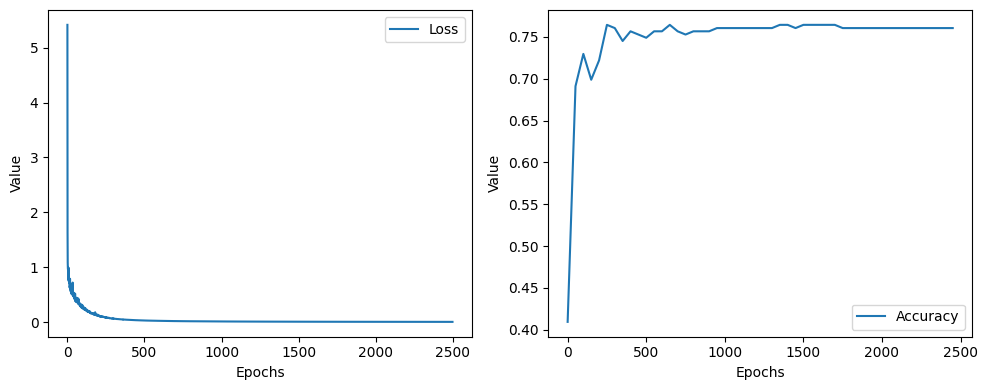

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(loss[:, 0], loss[:, 1], label='Loss')
axs[1].plot(acc[:, 0], acc[:, 1], label='Accuracy')

for ax in axs:
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

Jak widac po funkcji straty model sigmoidowy bardzo szybko znalazl lokalne minimum, jednak nie bylo to lokalne mimimum, ktore pozwoliloby mu na zminimalizowanie bledu dla augmentowanego datasetu. Moze to wynikac z faktu, ze to wlasnie to pozytywne wartosci (jasne linie wytworzone przez filtr sobel'a) niosa ze soba wiecej informacji na temat klasy danej probki; wartosci, ktorym model sigmoidowy przyklada mniej uwagi niz model relu. W przypadku modelu z aktywacja ReLU widac, ze model rowniez szybko znalazl lokalne minimum, jednak accuracy modelu jest znacznie wyzsze niz modelu z aktywacja sigmoid. 

Jak widac dobor funkcji aktywacji musi byc scisle powiazany z danymi, na ktorych model bedzie wykonywac inferencje